# Streaming Data Visualisation

Plotting the line graph of air temperature against arrival time from incoming climate data.


<IPython.core.display.Javascript object>


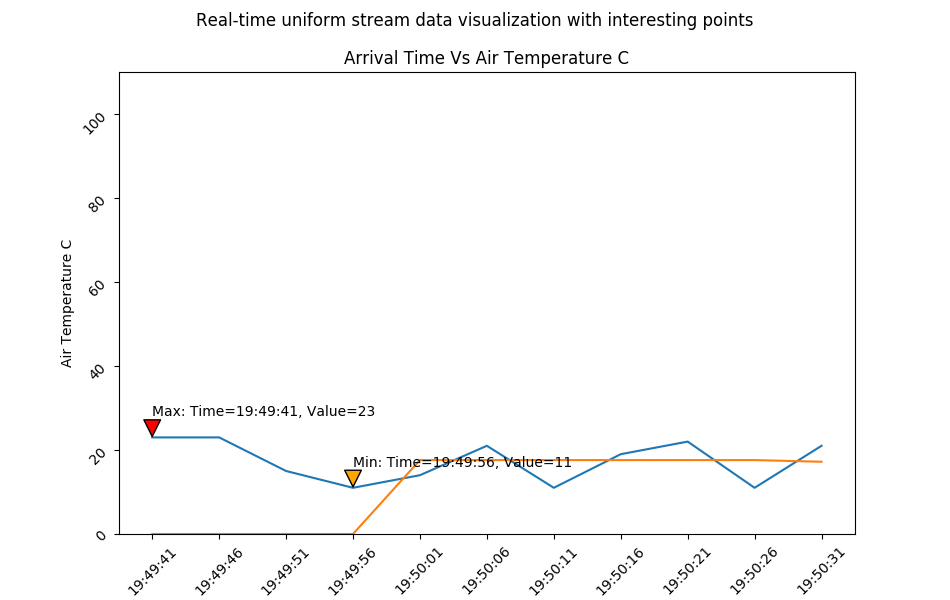

KeyboardInterrupt: 

In [1]:
# import statements
from time import sleep,strftime, localtime
from json import loads
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import statistics

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'hotspot'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Time')
        ax1.tick_params(labelrotation=45)
        ax1.set_ylabel('air_temperature_celcius')
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax1):
    try:
        # container for x and y values
        x1, y1, y2 = [], [], []
        check = 0
        # print('Waiting for messages')
        for message in consumer:
            
            time = dt.datetime.now().strftime("%X") #For arrival time
            message=message.value
            if message["sender_id"] == "producer_1":
                x1.append(time) 
                y1.append(message['air_temperature_celcius'])
                if len(y1) > 5:
                    # print (y1[:5])
                    y2.append(statistics.mean(y1[:5]))
                else:
                    y2.append(0)
                    # print(y)
                # we start plotting only when we have 10 data points
                if len(y1) > 10:

                    ax1.clear()
                    ax1.plot(x1, y1)
                    ax1.plot(x1, y2)
                    ax1.set_xlabel('Arrival Time')
                    ax1.set_ylabel('Air Temperature C')
                    ax1.set_title('Arrival Time Vs Air Temperature C')
                    ax1.set_ylim(0,110) 
                    ax1.set_yticks([0,20,40,60,80,100])
                    annotate_max(x1, y1, ax1)
                    annotate_min(x1, y1, ax1)

                    fig.canvas.draw()
                    x1.pop(0) # removing the item in the first position
                    y1.pop(0)
                    y2.pop(0)
                   
        
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)
    
    

# Static Data Visualisation


* Records with the top 10 number of fires. Plot a bar chart with time as the x-axis and number of fires as the y-axis.


Text(0.5, 1.0, 'Bar Chart showing number of fires at different times')

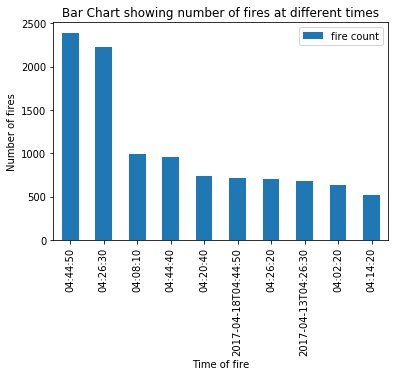

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
%matplotlib inline

client = MongoClient()
db = client.fit5148_assignment_db
fire = db.historic
climate = db.climate
##Preparing the data for plotting Bar Chart:
FireList = []

cursor = db.historic.aggregate([
{"$group":{"_id":"$datetime", "fire count":{"$sum":1}}},
{"$sort":{"fire count": -1}},
{"$limit": 10}
])

##Adding the query results to dictionary FireList
for document in cursor:
    FireList.append(document)

##Converting dictionary called FireList to Data Frame called fire_table to plot bar chart
fire_table = pd.DataFrame.from_dict(FireList)
#print(fire_table)

##Plotting bar chart with time as x-axis and number of fires as y-axis:

ax = fire_table.plot.bar(x='_id', y='fire count', rot=90)

ax.set_ylabel('Number of fires')
ax.set_xlabel('Time of fire')
ax.set_title('Bar Chart showing number of fires at different times')


###  Plot fire locations in the map with air temperature, surface temperature, relative humidity and confidence.

In [10]:
from pymongo import MongoClient

client = MongoClient()
db = client.fit5148_assignment_db
fire = db.fire
climate = db.climate
historic = db.historic

In [12]:
# Preparing data for plotting map:
historic_info = historic.find()
    
fire_info = []
for row in historic_info:
    
  
        # Adding the latitude and longitude to the list called fire_info
        fire_info.append((float(row['latitude']), float(row['longitude']), float(row['surface_temperature_celcius']), float(row['confidence']), float(row['climate']['relative_humidity']), float(row['climate']['air_temperature_celcius'])))

KeyError: 'climate'

In [13]:
# Unzipping the set and preparing it to use with function marker of gmplot:
fire_latitude, fire_longitude, surface_temperature_celcius, confidence, relative_humidity, air_temperature_celcius = zip(*fire_info) 

ValueError: not enough values to unpack (expected 6, got 0)

In [14]:
import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city


#fire_latitude, fire_longitude, surface_temperature_celcius, confidence, relative_humidity, air_temperature_celcius 
for j in range(len(fire_latitude)):
    text = 'surface temp:' + str(surface_temperature_celcius[j]) + ', confidence:' + str(confidence[j]) + ', air temp:' + str(air_temperature_celcius[j]) + ', humidity:' + str(relative_humidity[j])
    gmap.marker(fire_latitude[j], fire_longitude[j], title=text)

NameError: name 'fire_latitude' is not defined

In [15]:
import webbrowser
# Drawing the map
gmap.draw("fire_location.html")
webbrowser.open_new("fire_location.html")

True